In [1]:
import numpy as np
import torch
from torch import nn
import LightPipes as lp
import matplotlib.pyplot as plt
from modes.vortex import Vortex
from modes.zernike import Zernike
from modes.pixel import Pixel

from sklearn import linear_model

truncate_circle = False

Load the Modes and the derivatives

In [74]:
microlens = 20 #20x20
size = microlens

n_zernike = 4

x = np.linspace(-1,1,size)
y = np.linspace(-1,1,size)

zer, dzerdx, dzerdy = Zernike(n_zernike,x,y,truncate_circle=truncate_circle)

vor, dvordx, dvordy = Vortex(2,x,y,truncate_circle=truncate_circle)

pix, dpixdx, dpixdy = Pixel(x,y,)





# modes = np.concatenate((zer,vor,pix),axis=0)
# dmodesdx = np.concatenate((dzerdx,dvordx,dpixdx),axis=0)
# dmodesdy = np.concatenate((dzerdy,dvordy,dpixdy),axis=0)

modes = np.concatenate((zer,),axis=0)
dmodesdx = np.concatenate((dzerdx,),axis=0)
dmodesdy = np.concatenate((dzerdy,),axis=0)

Make a custom wavefront...

Text(0.5, 1.0, 'True Wavefront')

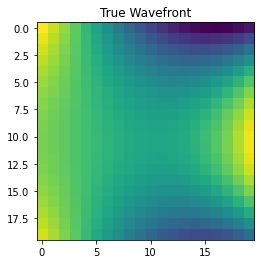

In [75]:
mode_coeffs = np.zeros((len(modes),1,1))

elements = np.arange(len(zer))
np.random.shuffle(elements)
elements = elements

zer_coeffs = np.random.rand(len(elements),1,1)

decenter = [0.1,0.1]

shift_zer, _, _ = Zernike(n_zernike,x,y,x0=decenter[0],y0=decenter[1],truncate_circle=truncate_circle)

shift_zer = shift_zer / np.max(shift_zer,axis=(1,2),keepdims=True) #normalize


wavefront = shift_zer[9] + shift_zer[5]


# wavefront = np.sum(zer * zer_coeffs,axis=0)

# wavefront += Vortex(2,x,y, x0=.1, y0=.1, truncate_circle=truncate_circle)[0][0]


plt.imshow(wavefront); plt.title('True Wavefront')

#### Lets calc gradients


In [76]:
positions = np.arange(microlens,dtype=int)
xx,yy = np.meshgrid(positions,positions)


In [77]:
dx, dy = np.gradient(wavefront)


sampled_gradient = np.zeros((2,microlens,microlens))

mode_gradients = np.zeros((2,microlens,microlens,len(modes)))

for i in range(microlens):
    for j in range(microlens):
        sampled_gradient[0,i,j] = dx[int(xx[i,j]),int(yy[i,j])]
        sampled_gradient[1,i,j] = dy[int(xx[i,j]),int(yy[i,j])]
        mode_gradients[0,i,j] = dmodesdx[:,int(xx[i,j]),int(yy[i,j])]
        mode_gradients[1,i,j] = dmodesdy[:,int(xx[i,j]),int(yy[i,j])]



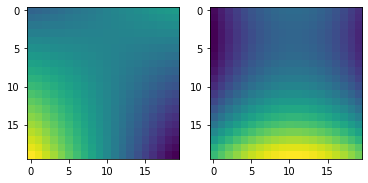

In [78]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(sampled_gradient[0])
ax[1].imshow(sampled_gradient[1])

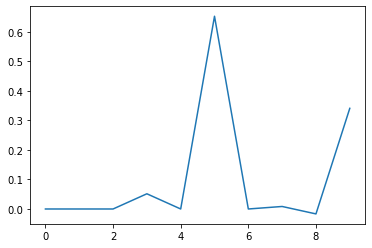

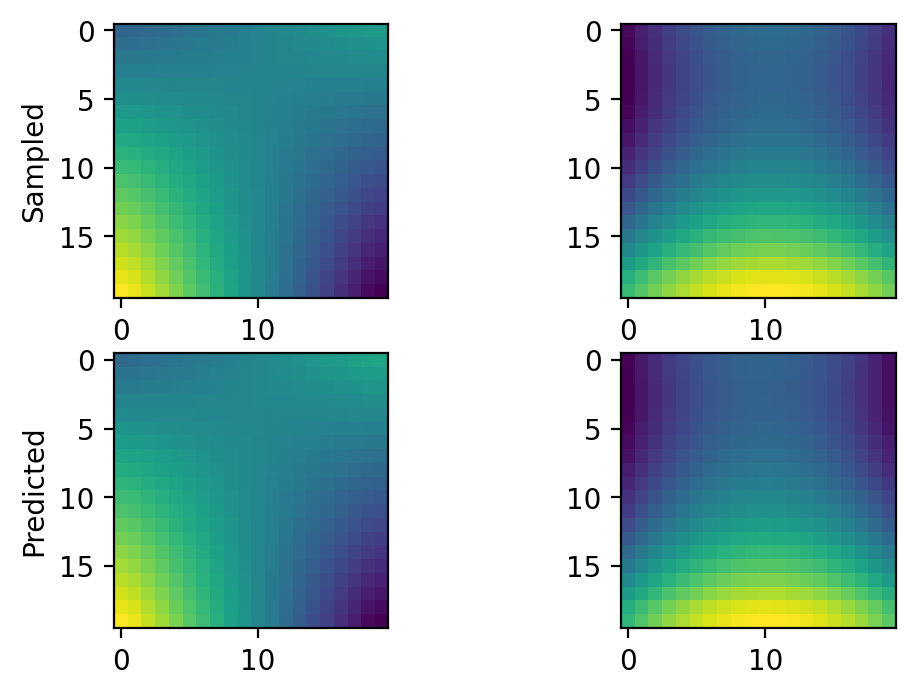

In [79]:
t = sampled_gradient.reshape(-1,1)
u = mode_gradients.reshape(-1,mode_gradients.shape[-1])

clf = linear_model.Lasso(alpha=0.001)
clf.fit(u,t)
result_vector = clf.coef_

wavefront_grad_prediction = (mode_gradients @ result_vector)
plt.figure()
plt.plot(result_vector)


fig,ax = plt.subplots(2,2,dpi=200)
ax[0,0].imshow(sampled_gradient[0]); ax[0,0].set_ylabel('Sampled')
ax[0,1].imshow(sampled_gradient[1])
ax[1,0].imshow(wavefront_grad_prediction[0]); ax[1,0].set_ylabel('Predicted')
ax[1,1].imshow(wavefront_grad_prediction[1])


In [21]:
u = torch.tensor(u).permute(1,0).float()

t = torch.tensor(t).permute(1,0).float()

In [22]:
coefficients = torch.nn.Parameter(torch.rand(1,u.shape[0]))
offset = torch.nn.Parameter(torch.zeros(2))

reg_coeff = 5e-3


history2 = {} # Collects per-epoch loss and acc like Keras' fit().
history2['loss'] = []


In [23]:
lr = 5e-4


epochs = 8000

optimizer = torch.optim.Adam([coefficients], lr=lr)
loss_fn = torch.nn.MSELoss()



for epoch in range(1, epochs+1):
    # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
    # seq_model.train()
    num_train_examples = 1

    optimizer.zero_grad()
    
    # coeff_preds = torch.nn.functional.relu(seq_model(x)) #take the gradients for every mode

    pred = (coefficients @ u)

    mse = loss_fn(pred, t)

    reg = torch.norm(coefficients,1) / coefficients.size()[0]

    loss = mse + reg * reg_coeff

    loss.backward()
    optimizer.step()

    



    print(f'Epoch {epoch}/{epochs}:, train mse: {mse:5.5g}, train reg: {reg*reg_coeff:5.5g}',end='\r')


    history2['loss'].append(loss.item())

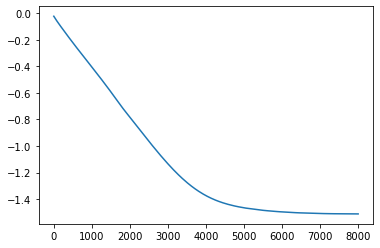

In [25]:
plt.plot(np.log10(history2['loss']))

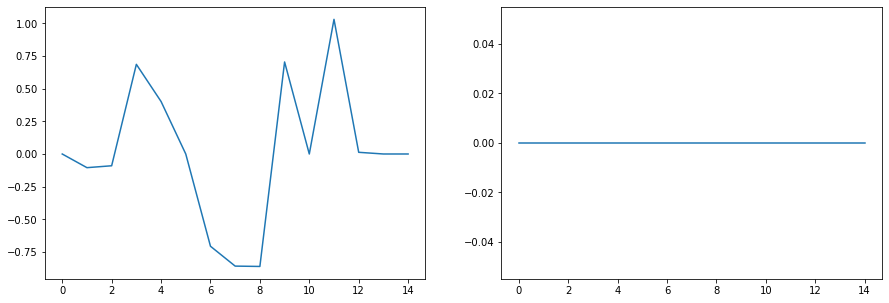

In [26]:

fig,ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(coefficients[0].detach())
ax[1].plot(mode_coeffs[:,0,0])

In [27]:
pred_gradients = pred.reshape(2,20,20).detach().numpy()

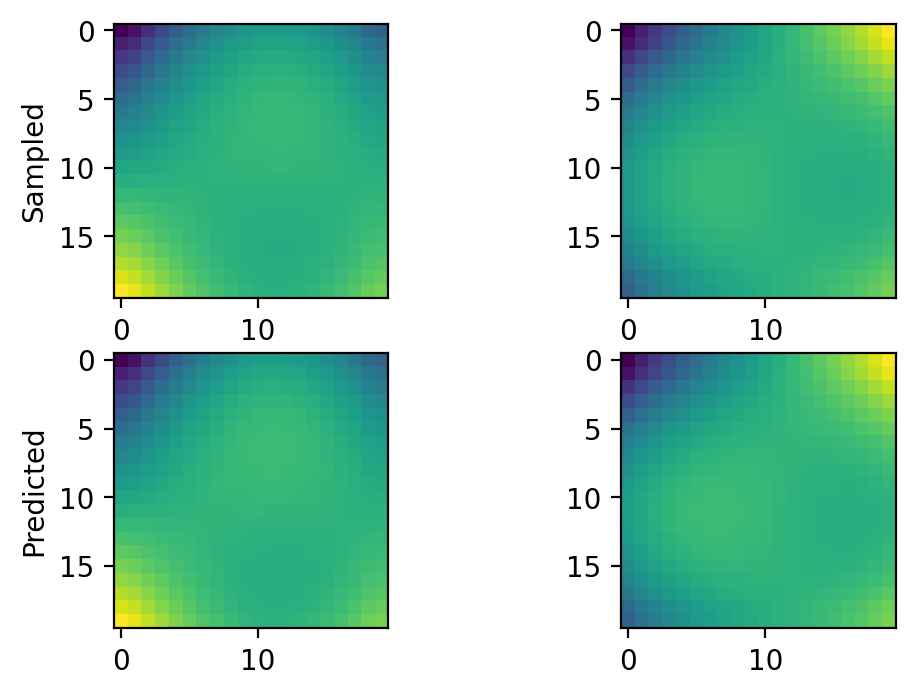

In [28]:
fig,ax = plt.subplots(2,2,dpi=200)
ax[0,0].imshow(sampled_gradient[0]); ax[0,0].set_ylabel('Sampled')
ax[0,1].imshow(sampled_gradient[1])
ax[1,0].imshow(pred_gradients[0]); ax[1,0].set_ylabel('Predicted')
ax[1,1].imshow(pred_gradients[1])
